In [ ]:
"""
Purpose: To run graph coarsening models in order
to embed a graph in a latent space for 
unsupervised clustering or classification
"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/datasci_tools/datasci_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")

import datajoint_utils as du
from importlib import reload

WARNING - 2022-04-25 21:50:43,790 - _default - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Using default Google credentials. There is no ~/.cloudvolume/secrets/google-secret.json set.


INFO - 2022-04-25 21:50:45,627 - settings - Setting enable_python_native_blobs to True
INFO - 2022-04-25 21:50:45,628 - settings - Setting stores to {'h01_skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/skeletons', 'stage': '/mnt/dj-stor01/microns/h01/skeletons'}, 'h01_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/meshes', 'stage': '/mnt/dj-stor01/microns/h01/meshes'}, 'h01_faces': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/faces', 'stage': '/mnt/dj-stor01/microns/h01/faces'}, 'h01_decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/decimated_meshes', 'stage': '/mnt/dj-stor01/microns/h01/decimated_meshes'}, 'h01_soma_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/soma_meshes', 'stage': '/mnt/dj-stor01/microns/h01/soma_meshes'}}
INFO - 2022-04-25 21:50:45,640 - connection - Connected celiib@at-database.ad.bcm.edu:3306


Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2022-04-25 21:50:46,729 - settings - Setting enable_python_native_blobs to True
WARNING - 2022-04-25 21:50:50,934 - utils - DataJointPlus version check failed.
INFO - 2022-04-25 21:50:54,497 - settings - Setting enable_python_native_blobs to True
ERROR - 2022-04-25 21:50:54,590 - compatibility - Could not add DataJointPlus to ImportMethod.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info_from_header
    if result[0] == attr:
IndexError: list index out of range
ERROR - 2022-04-25 21:50:54,814 - compatibility - Could not add DataJointPlus to Materialization.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info

In [3]:
from dataInterfaceMinnie65 import data_interface as hdju

# 1) Gathering the Data

In [4]:
m65mor,m65auto = hdju.schema_mor,hdju.schema_auto

# -- Getting the cell type labels -- 

In [5]:
import cell_type_utils as ctu
df = ctu.cell_type_df_allen_bcm(verbose = True)
df_fine = ctu.df_cell_type_fine(df)

---Working on bodor_pt_cells---
---Working on allen_column_l5it_types---
---Working on allen_column_basket_molecular---
---Working on allen_column_bodor_surround_inhib---
---Working on cg_cell_type_calls---
---Working on l5_mc_cg---
---Working on allen_v1_column_types_slanted---
---Working on allen_minnie_extra_types---
---Working on allen_v1_column_types_v2---
---Working on allen_v1_column_pyc_proof---
len(cell_type_allen) = 4253
len(cell_type_bcm) = 585
len(cell_type_df) before filtering = 4818
len(cell_type_df) after filtering = 4818


In [6]:
import pandas_utils as pu
df_fine = pu.rename_columns(df_fine,dict(cell_type_fine = "cell_type_fine_label"))
df_fine

,pt_root_id,cell_type_fine_label,cell_type_coarse,table_of_origin,nucleus_id,pt_position
0,864691135660737776,5P_PT,excitatory,bodor_pt_cells,526436,"[304160, 185008, 17299]"
1,864691135472306482,5P_PT,excitatory,bodor_pt_cells,495010,"[287632, 192944, 19549]"
2,864691135494401680,5P_PT,excitatory,bodor_pt_cells,494888,"[285712, 190768, 19231]"
3,864691135502157405,5P_PT,excitatory,bodor_pt_cells,337966,"[203520, 194512, 22991]"
4,864691135476398504,5P_PT,excitatory,bodor_pt_cells,302951,"[181952, 207456, 20474]"
...,...,...,...,...,...,...
4248,864691136143621428,6CT,excitatory,allen_v1_column_types_v2,308966,"[187712, 253376, 21640]"
4249,864691135155758180,6CT,excitatory,allen_v1_column_types_v2,271535,"[171632, 240352, 21767]"
4250,864691136005061066,MC,inhibitory,allen_v1_column_types_v2,308834,"[186704, 244768, 20391]"
4251,864691136237708604,6P,excitatory,allen_v1_column_types_v2,273832,"[177104, 249808, 22290]"


# Getting the Actual Graph Data

In [15]:
import system_utils as su
gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"

# Step 1: Loading the data

In [8]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [9]:
from pathlib import Path
data_path = Path("../Data_Prep")

data_file = "df_cell_type_fine.pbz2"
data_filepath = Path(data_path) / Path(data_file)

data_filepath.exists()

True

In [10]:
import system_utils as su
data_df = su.decompress_pickle(data_filepath)
data_df

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
0,864691134884741626,0,326888,LAYER_2/3,V1,"[{'nodelist': ['L0_22', 'L0_21', 'L0_23', 'L0_...",NaN
1,864691134884748026,0,366181,LAYER_5,V1,"[{'nodelist': ['L0_10', 'L0_11', 'L0_12', 'L0_...",4P
2,864691134884749818,0,330319,LAYER_4,V1,"[{'nodelist': ['L0_6', 'L0_7', 'L0_8', 'L0_5',...",NaN
3,864691134884750074,0,326374,LAYER_2/3,V1,"[{'nodelist': ['L0_33', 'L0_29', 'L0_36', 'L0_...",NaN
4,864691134884750842,0,490973,LAYER_4,RL,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_3',...",NaN
...,...,...,...,...,...,...,...
12828,864691137197182273,0,335443,LAYER_5,V1,"[{'nodelist': ['L0_20', 'L0_14', 'L0_19', 'L0_...",NaN
12829,864691137197188161,0,296634,LAYER_4,V1,"[{'nodelist': ['L0_17', 'L0_0', 'L0_14', 'L0_7...",23P
12830,864691137197196865,0,299940,LAYER_5,V1,"[{'nodelist': ['L0_1', 'L0_5', 'L0_7', 'L0_6',...",NaN
12831,864691137197232961,0,553624,LAYER_2/3,RL,"[{'nodelist': ['L0_31', 'L0_32', 'L0_34', 'L0_...",NaN


In [11]:
"""
Note the cell_type_fine is the column
that has all of the graph data stored
"""

'\nNote the cell_type_fine is the column\nthat has all of the graph data stored\n'

In [12]:
data_dict = data_df[["cell_type_fine"]].iloc[0].to_list()[0][0]
data_dict.keys()

dict_keys(['nodelist', 'features', 'adjacency', 'feature_matrix', 'label_name', 'graph_label'])

In [13]:
data_dict["graph_label"]

# Step 1: Creating the Dataset

# -- a) Getting Means and Std Dev for Normalization --

In [16]:
import pandas as pd
import pandas_utils as pu
import numpy as np
import numpy_utils as nu
import neuron_nx_io as nxio
all_batch_df = pd.concat([nxio.feature_df_from_gnn_info(
    k[0],
    return_data_labels_split = False) for k in data_df[gnn_task].to_list()])

if label_name is not None:
    all_batch_df = all_batch_df[[k for k in 
            all_batch_df.columns if k not in nu.convert_to_array_like(label_name)]]
else:
    all_batch_df = all_batch_df
    
# will use these to normalize the data
col_means = all_batch_df.mean(axis=0).to_numpy()
col_stds = all_batch_df.std(axis=0).to_numpy()

all_batch_df_norm = pu.normalize_df(all_batch_df,column_means=col_means,
                                 column_stds = col_stds)
all_batch_df_norm.std()

mesh_volume                         1.0
n_spines                            1.0
n_synapses_head                     1.0
n_synapses_neck                     1.0
n_synapses_post                     1.0
n_synapses_pre                      1.0
skeletal_length                     1.0
total_spine_volume                  1.0
width_upstream                      1.0
width_downstream                    1.0
apical_label                        1.0
axon_label                          1.0
basal_label                         1.0
skeleton_vector_downstream_phi      1.0
skeleton_vector_downstream_theta    1.0
skeleton_vector_upstream_phi        1.0
skeleton_vector_upstream_theta      1.0
width_no_spine                      1.0
dtype: float64

# --- b) Creating the Dataset Class --

In [17]:
# -- mapping of the labels to integers --
total_labels = (data_df.query("cell_type_fine_label==cell_type_fine_label")[
    "cell_type_fine_label"]).unique()
cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
cell_type_map[None] = 0
cell_type_map

{'4P': 1,
 'IT_short': 2,
 '6P_CT': 3,
 '23P': 4,
 '5P_IT': 5,
 '6P_IT': 6,
 '5P_PT': 7,
 '6P': 8,
 'IT_big_tuft': 9,
 'IT_small_tuft': 10,
 '5P_NP': 11,
 '1P': 12,
 '6P_U': 13,
 None: 0}

In [18]:
import pandas as pd
import networkx_utils as xu
import neuron_nx_io as nxio
from torch_geometric.data import Data
import numpy as np
def pytorch_data_from_gnn_info(
    gnn_info,
    y = None,
    verbose = False,
    normalize = True): 
    """
    Purpose: To convert our data format into pytorch Data object

    Pseudocode: 
    1) Create the edgelist (turn into tensor)
    2) Get the 
    """
    edgelist = torch.tensor(xu.edgelist_from_adjacency_matrix(
        array = gnn_info["adjacency"],
        verbose = False,
    ).T,dtype=torch.long)

    x,y_raw = nxio.feature_df_from_gnn_info(
        gnn_info,
        return_data_labels_split = True)
    if y is None:
        y = y_raw
        
    if not type(y) == str:
        y = None
        
    y_int = np.array(cell_type_map[y] ).reshape(1,-1)
    
    if normalize:
        x = (x-col_means)/col_stds

    x = torch.tensor(x,dtype=torch.float)
    y = torch.tensor(y_int,dtype=torch.long)


    if verbose:
        print(f"x.shape = {x.shape},y.shape ={y.shape}")

    data = Data(x=x,y=y,edge_index=edgelist)
    return data


In [54]:
import torch
from torch_geometric.data import InMemoryDataset, download_url
from tqdm_utils import tqdm
import system_utils as su

class CellTypeDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        #return ['some_file_1', 'some_file_2', ...]
        return [str(data_filepath.absolute())]

    @property
    def processed_file_names(self):
        return ['data.pt']

    # def download(self):
    #     # Download to `self.raw_dir`.
    #     download_url(url, self.raw_dir)
    #     ...

    def process(self):
        # Read data into huge `Data` list.
        #data_list = [...]

#         if data_df is None:
#             data_df = su.decompress_pickle(self.raw_file_names[0])

        data_list = []
        for k,y in tqdm(zip(
            data_df[gnn_task].to_list(),
            data_df[graph_label].to_list())):
            data_list.append(pytorch_data_from_gnn_info(
                k[0],
                y=y))

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
            

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [55]:
# setting up the folder
processed_data_folder = data_path / Path(f"{gnn_task}_processed_GAE")
processed_data_folder.mkdir(exist_ok = True)

In [56]:
from torch_geometric import transforms
from torch_geometric.utils import train_test_split_edges

transform_norm = transforms.Compose([
    transforms.ToUndirected(),
    #train_test_split_edges,
    #transforms.NormalizeFeatures(),
])

dataset = CellTypeDataset(
    processed_data_folder.absolute(),
    pre_transform = transform_norm
    )

Processing...


0it [00:00, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 125 but got size 50 for tensor number 1 in the list.

In [ ]:
# looking at the dataset
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# --- c) Splitting the Data into Labeled and unlabeled

In [41]:
labeled_mask = np.array(
    [True if k.y > 0 else False for k in dataset]
)
dataset_labeled = dataset[labeled_mask]
dataset_labeled

CellTypeDataset(1122)

In [42]:
dataset_curr = dataset
torch.manual_seed(12345)
dataset_curr = dataset_curr.shuffle()

# --- d) Split Test/Train

In [49]:
batch_size = 64

In [64]:
from torch_geometric.loader import DataLoader
import numpy as np
n_train = int(len(dataset_curr)*0.7)
n_test = len(dataset_curr) - n_train

test_ratio = 0.3
val_ratio = 0
dataset_curr = [train_test_split_edges(k,
                test_ratio = test_ratio,
                        val_ratio = val_ratio) for k in dataset_curr]

train_loader = dataset_curr[:n_train]
test_loader = dataset_curr[n_train:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Number of training graphs: 8983
Number of test graphs: 3850


# Step 2: Creating The Model

# -- Variational Autoencoder --

In [72]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool,global_add_pool,global_mean_pool,global_sort_pool

from torch_geometric.nn import VGAE

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(
        self,
        dataset_num_node_features,
        n_hidden_channels,
        activation_function = "relu",):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(dataset_num_node_features, 2 * n_hidden_channels, cached=False) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * n_hidden_channels, n_hidden_channels, cached=False)
        self.conv_logstd = GCNConv(2 * n_hidden_channels, n_hidden_channels, cached=False)
        self.act_func = getattr(F,activation_function)
        
    def forward(self, x, edge_index):
        x = self.act_func(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)



# Step 3: Training the Model

In [131]:
model_name = "GVAE"
n_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cpu


In [132]:
import geometric_models as gm

architecture_kwargs = dict(
    n_hidden_channels=32,
    #n_layers = 2,
    activation_function = "relu",
    #global_pool_type="mean",
)

model = VGAE(VariationalGCNEncoder(
    num_features, out_channels))  # new line
    

model = VGAE(VariationalGCNEncoder(
    dataset_num_node_features=dataset.num_node_features,
    #dataset_num_classes=dataset.num_classes,
    **architecture_kwargs
    ))

model = model.to(device)
print(model)


VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(18, 64)
    (conv_mu): GCNConv(64, 32)
    (conv_logstd): GCNConv(64, 32)
  )
  (decoder): InnerProductDecoder()
)


In [133]:
from torch.utils.tensorboard import SummaryWriter

tensorboard_dir = Path("./tensorboard")
tensorboard_dir.mkdir(exist_ok=True)

tensorboard_file_name = (f'{model_name}' 
                         + "_".join([f"{k}_{v}" for k,v in architecture_kwargs.items()]))
print(f"tensorboard_file_name = {tensorboard_file_name}")
tensorboard_file = tensorboard_dir / Path(f'{model_name}')
writer = SummaryWriter(tensorboard_file)

tensorboard_file_name = GVAEn_hidden_channels_32_activation_function_relu


In [134]:
import evaluation_utils as evu

print(model)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
test_ratio = 0.3

# weights = weight#[0.1,0.5,,1,0.7,1,1,1]
# class_weights = torch.FloatTensor(weights).to(device)
class_weights = None
tensor_map = None

import random

def train():
    model.train()
    random.shuffle(train_loader)
    loss = 0
    total_loss = 0
    for i,data in enumerate(train_loader):  # Iterate in batches over the training dataset.
        data = data.to(device)
        train_pos_edge_index = data.train_pos_edge_index.to(device)
        x = data.x
        
        z = model.encode(x, train_pos_edge_index)
        loss += model.recon_loss(z, train_pos_edge_index)
        loss += loss + (1 / data.num_nodes) * model.kl_loss()  # new line
        total_loss += loss
        
        if i%batch_size == batch_size-1 or i == len(dataset):
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            loss = 0
    
    return total_loss/len(train_loader)


def test(loader,verbose = False):
    auc,ap = [],[]
    model.eval()
    for data in loader:
        data = data.to(device)
        train_pos_edge_index = data.train_pos_edge_index.to(device)
        pos_edge_index, neg_edge_index = data.test_pos_edge_index, data.test_neg_edge_index
        x = data.x
        with torch.no_grad():
            z = model.encode(x, train_pos_edge_index)

        try:
            (auc_singular, 
            ap_singular) = model.test(z, pos_edge_index, neg_edge_index)
        except:
            continue
        
        auc.append(auc_singular)#.detach().cpu().numpy())
        ap.append(ap_singular)#.detach().cpu().numpy())

    return dict(auc_mean = np.mean(auc),
                ap_mean = np.mean(ap))

log_to_tensorboard = True
for epoch in range(0, n_epochs):
    loss = train()
    writer.add_scalar('loss',loss,epoch) # new line
    train_metric_dict = test(train_loader)
    test_metric_dict = test(test_loader)
    print(f'Epoch: {epoch:03d}, loss = {loss}')
    for type_name,metric_dict in zip(["train","test"],[train_metric_dict,test_metric_dict]):
        print_log = f"   {type_name} metrics: "
        for k,v in metric_dict.items():
            if log_to_tensorboard:
                writer.add_scalar(f'{type_name}_{k}',v,epoch)
            print_log += f" {k}: {v:4f},"
            
        print(print_log)

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(18, 64)
    (conv_mu): GCNConv(64, 32)
    (conv_logstd): GCNConv(64, 32)
  )
  (decoder): InnerProductDecoder()
)
Epoch: 000, loss = 1.2288834204545424e+20
   train metrics:  auc_mean: 0.783653, ap_mean: 0.785971,
   test metrics:  auc_mean: 0.780682, ap_mean: 0.782767,
Epoch: 001, loss = 1.4811687438904197e+18
   train metrics:  auc_mean: 0.801590, ap_mean: 0.794352,
   test metrics:  auc_mean: 0.798960, ap_mean: 0.791352,
Epoch: 002, loss = 1.484584101884199e+18
   train metrics:  auc_mean: 0.777681, ap_mean: 0.783342,
   test metrics:  auc_mean: 0.775396, ap_mean: 0.780971,
Epoch: 003, loss = 1.434003955666387e+18
   train metrics:  auc_mean: 0.786988, ap_mean: 0.787706,
   test metrics:  auc_mean: 0.784196, ap_mean: 0.785576,
Epoch: 004, loss = 1.4438447221739356e+18
   train metrics:  auc_mean: 0.785391, ap_mean: 0.786495,
   test metrics:  auc_mean: 0.782998, ap_mean: 0.784696,
Epoch: 005, loss = 1.4315546560765624e+

Epoch: 052, loss = 1.8044055086862172e+18
   train metrics:  auc_mean: 0.713485, ap_mean: 0.739289,
   test metrics:  auc_mean: 0.712980, ap_mean: 0.738068,
Epoch: 053, loss = 1.3990319267606692e+18
   train metrics:  auc_mean: 0.705483, ap_mean: 0.736050,
   test metrics:  auc_mean: 0.705360, ap_mean: 0.735017,
Epoch: 054, loss = 1.4609429526195732e+18
   train metrics:  auc_mean: 0.736769, ap_mean: 0.754905,
   test metrics:  auc_mean: 0.735141, ap_mean: 0.752768,
Epoch: 055, loss = 1.423486714629849e+18
   train metrics:  auc_mean: 0.723511, ap_mean: 0.745198,
   test metrics:  auc_mean: 0.721010, ap_mean: 0.741184,
Epoch: 056, loss = 1.3856679126808658e+18
   train metrics:  auc_mean: 0.712456, ap_mean: 0.739224,
   test metrics:  auc_mean: 0.710178, ap_mean: 0.735737,
Epoch: 057, loss = 1.4111089624801608e+18
   train metrics:  auc_mean: 0.723067, ap_mean: 0.745359,
   test metrics:  auc_mean: 0.721291, ap_mean: 0.742337,
Epoch: 058, loss = 1.401660721623728e+18
   train metrics: 

KeyboardInterrupt: 

# Step 4: Running Embedding for all cell types

In [135]:
import numpy as np
import tensor_utils as tu
model.eval()
embeddings = np.array([tu.numpy_array(model.encode(data.x,data.edge_index)) for data in dataset]).squeeze()

In [136]:
embeddings = np.array([np.mean(x,axis=0) for x in embeddings]).reshape(-1,32)
embeddings.shape

(12833, 32)

In [137]:
import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])
graph_labels = np.array([decoder_map[int(tu.numpy_array(k.y[0][0]))] for k in dataset])
graph_labels

array(['Unknown', '4P', 'Unknown', ..., 'Unknown', 'Unknown', '4P'],
      dtype='<U13')

In [138]:
labeled_mask_plotting = np.array([True if k != "Unknown" else False for k in graph_labels])
labeled_mask_plotting

array([False,  True, False, ..., False, False,  True])

In [139]:
np.unique(graph_labels,return_counts=True)

(array(['1P', '23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6P', '6P_CT',
        '6P_IT', '6P_U', 'IT_big_tuft', 'IT_short', 'IT_small_tuft',
        'Unknown'], dtype='<U13'),
 array([    4,   529,   387,   113,     2,    20,     4,     6,    17,
            2,    13,    15,    10, 11711]))

# Step 5: Plotting Embeddings

In [140]:
%matplotlib notebook
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

# PCA

In [141]:
X = embeddings#[labeled_mask_plotting]
y = graph_labels#[labeled_mask_plotting]

<IPython.core.display.Javascript object>


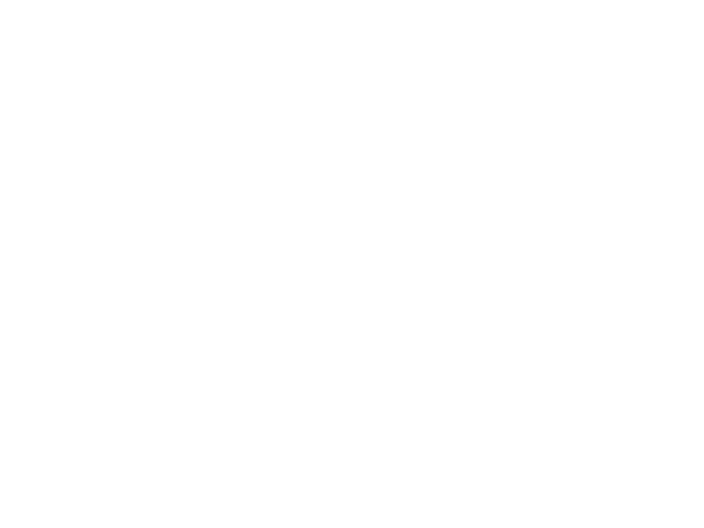

<IPython.core.display.Javascript object>


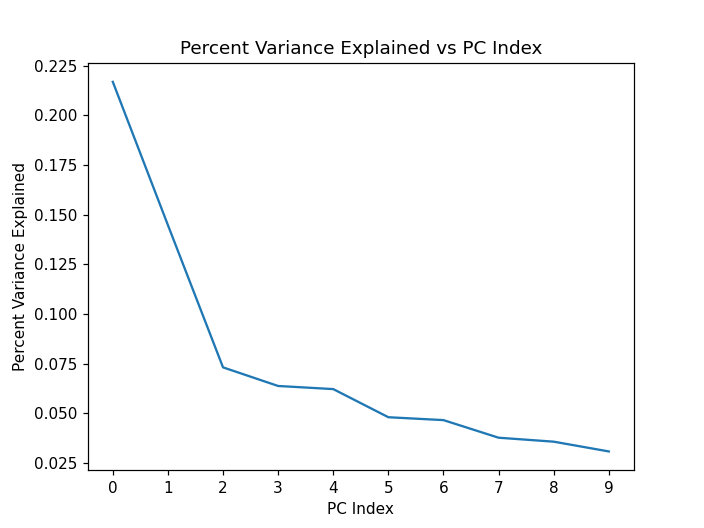

In [142]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

<IPython.core.display.Javascript object>


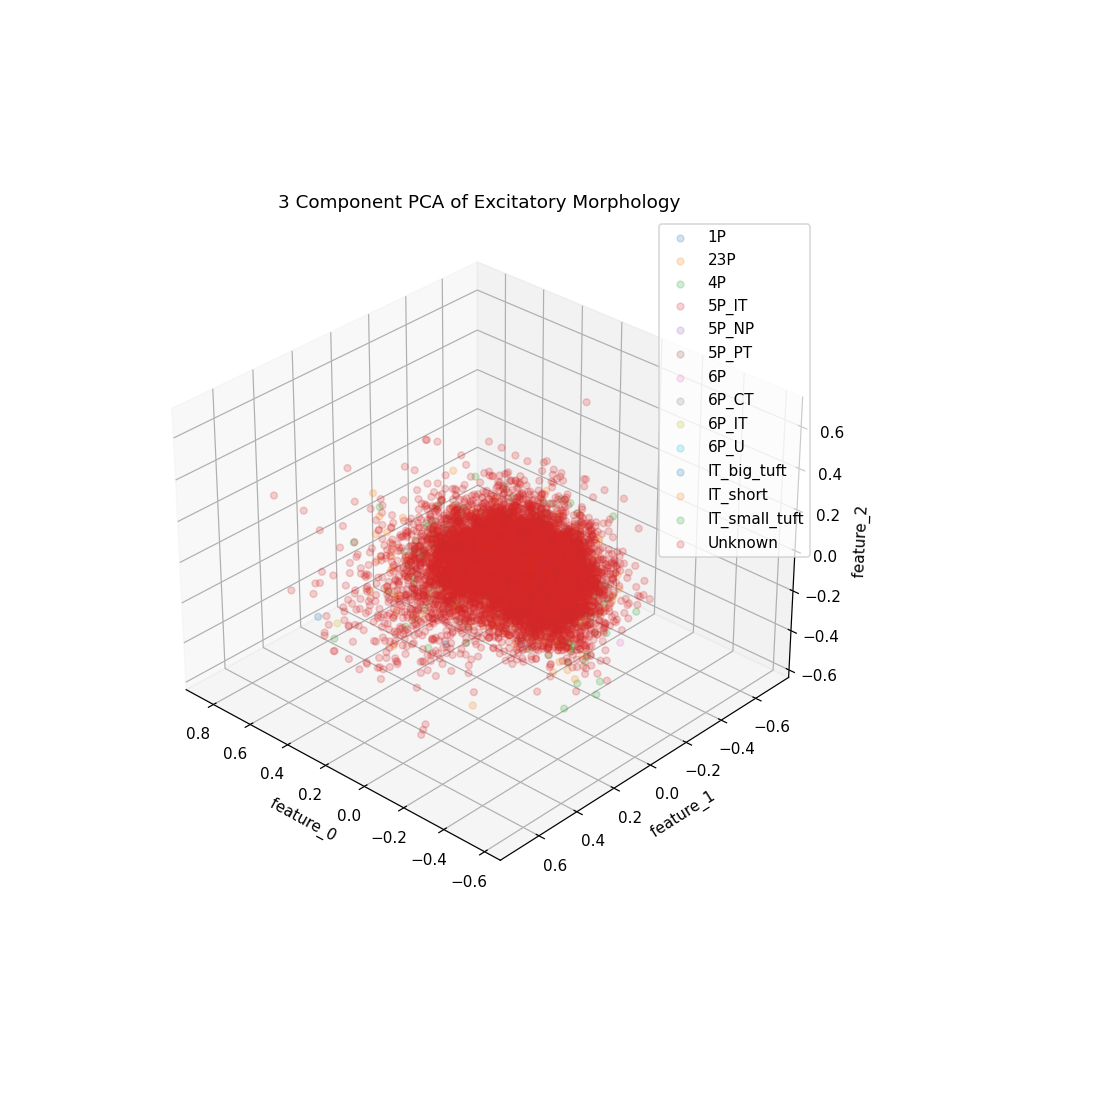

Text(0.5, 0.92, '3 Component PCA of Excitatory Morphology')

In [143]:
dim_red_name = "PCA"
W = pca_data["data_proj"][:,:n_components]

ax = vml.plot_df_scatter_3d_classification(
    X=W,
    y = y,
    alpha = 0.2
)

ax.set_title(f"3 Component {dim_red_name} of Excitatory Morphology")


# MDS

In [ ]:
from sklearn.manifold import MDS
mds_model = MDS(n_components=n_components)
#returns the transformed data

X = embeddings[labeled_mask_plotting]
y = graph_labels[labeled_mask_plotting]


W = mds_model.fit_transform(X)

dim_red_name = "MDS"
ax = vml.plot_df_scatter_3d_classification(
    X=W,
    y =y,
)

ax.set_title(f"3 Component {dim_red_name} of {model_name} Labeled")

# TSNE

In [144]:
dim_red_name = "TSNE"

In [145]:
from sklearn.manifold import TSNE
tsne_model = TSNE(
    n_components=n_components,
    #early_exaggeration = 4,
    #perplexity = 5
)

<IPython.core.display.Javascript object>


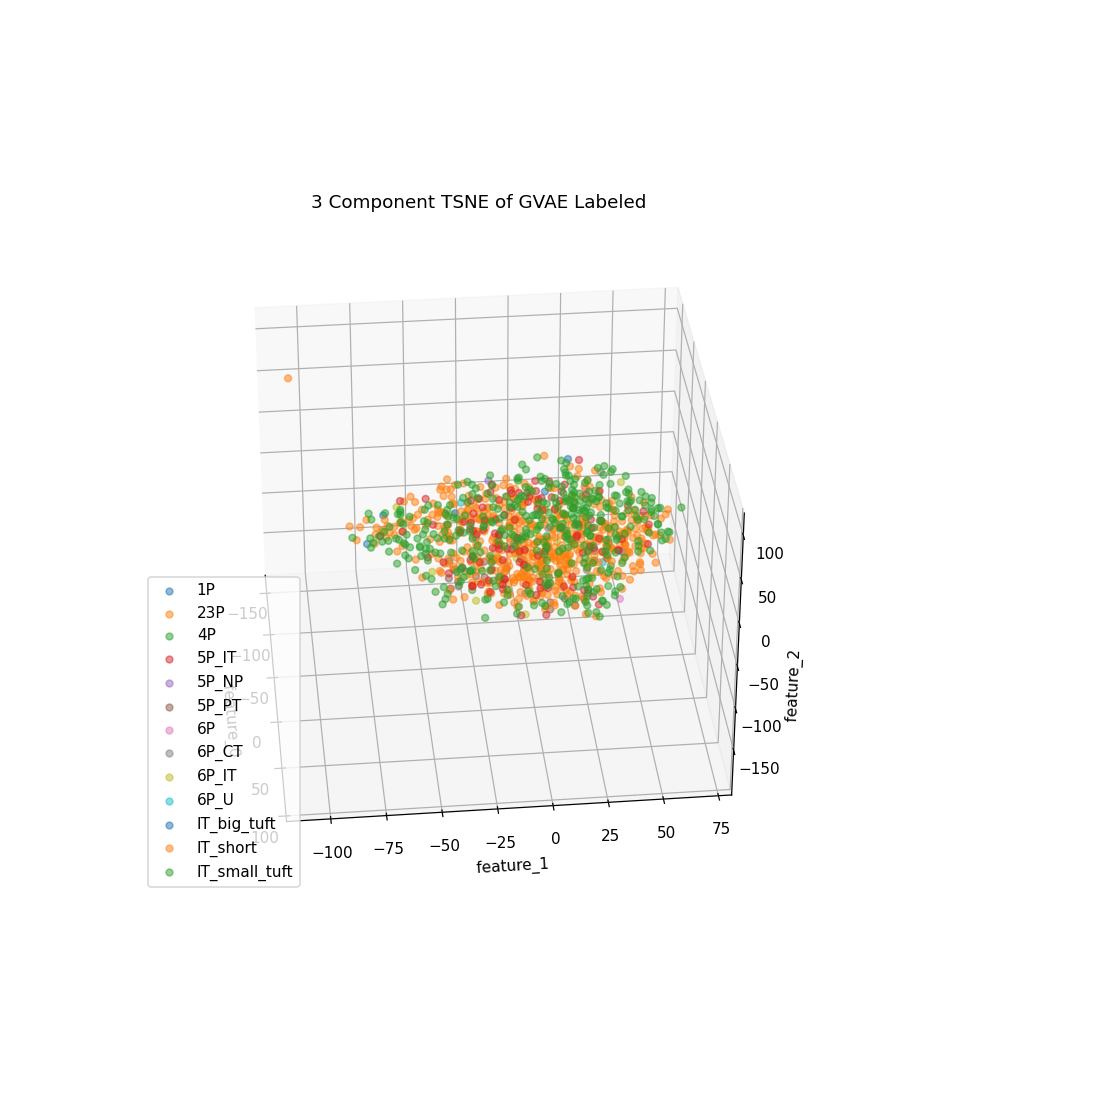

Text(0.5, 0.92, '3 Component TSNE of GVAE Labeled')

In [146]:
X = embeddings[labeled_mask_plotting]
y = graph_labels[labeled_mask_plotting]

W = tsne_model.fit_transform(X)

ax = vml.plot_df_scatter_3d_classification(
    X=W,
    y =y,
)

ax.set_title(f"3 Component {dim_red_name} of {model_name} Labeled")

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(
    n_components=n_components,
    early_exaggeration = 100,
    perplexity = 70
)

In [ ]:
X = embeddings#[labeled_mask_plotting]
y = graph_labels#[labeled_mask_plotting]

W = tsne_model.fit_transform(X)

ax = vml.plot_df_scatter_3d_classification(
    X=W,
    y =y,
)

ax.set_title(f"3 Component {dim_red_name} of {model_name} Labeled")